<a href="https://colab.research.google.com/github/tasniadristi/tasniadristi/blob/main/preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocess #

This script purpose is to generate the sample data on which to trained the model. It will load Landsat imagery and raster land cover from cloud storage then turn it into multiple grid/patch of smaller image/map to used to train the model. Then saved the the patch in the your local drive which can be loaded in `modelling.ipynb` script.

In [1]:
from google.colab import files

# Upload original file
uploaded = files.upload()

# Clean out Windows-only packages (like pywin32)
with open('requirements.txt', 'r') as f:
    lines = f.readlines()

filtered_lines = [line for line in lines if not line.strip().startswith('pywin32')]

with open('requirements_colab.txt', 'w') as f:
    f.writelines(filtered_lines)

# Install using the cleaned file
!pip install -r requirements_colab.txt


Saving requirements.txt to requirements.txt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.7/163.7 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.2 MB/s eta 0:00:00
ERROR: Ignored the following versions that require a different python version: 0.28.0 Requires-Python >=3.7, <3.11; 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10; 1.7.2 Requires-Python >=3.7,<3.11; 1.7.3 Requires-Python >=3.7,<3.11; 1.8.0 Requires-Python >=3.8,<3.11; 1.8.0rc1 Requires-Python >=3.8,<3.11; 1.8.0rc2 Requires-Python >=3.8,<3.11; 1.8.0rc3 Requires-Python >=3.8,<3.11; 1.8.0rc4 Requires-Python >=3.8,<3.11; 1.8.1 Requires-Python >=3.8,<3.11
ERROR: Could not find a version that satisfies the requirement tensorflow_intel==2.18.0 

In [3]:
!pip install tensorflow==2.18.0 tensorflow-io-gcs-filesystem==0.31.0

  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp311-cp311-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (14 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.1 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.37.1
    Uninstalling tensorflow-io-gcs-filesystem-0.37.1:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.37.1


In [5]:
!pip install rasterio

  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl.metadata (6.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 100.5 MB/s eta 0:00:00


In [6]:
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from rasterio.enums import Resampling
from PIL import ImageColor
from skimage.exposure import rescale_intensity

In [9]:
# Location of data
lc_dir = 'data/lc.json'
lc_image_dir = 'https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/LC_Image_v1.tif'
palsar_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Palsar_Kerinci_2023_v1.tif"
landsat_dir = "https://storage.googleapis.com/gee-ramiqcom-bucket/youtube/lc_python/Landsat_Kerinci_2023_v1.tif"

In [16]:
import json
import urllib.request

lc_url = 'https://raw.githubusercontent.com/ramiqcom/deep-learning-lc-unet/master/data/lc.json'
with urllib.request.urlopen(lc_url) as url:
    lc = json.load(url)

In [18]:
# Already loaded lc from URL earlier:
# lc = json.load(open(lc_dir)) → skip
lc_df = pd.DataFrame(lc)
# Load Land Cover Parameter
#lc = json.load(open(lc_dir))
lc_df = pd.DataFrame(lc)
lc_df["values_normalize"] = lc_df.index + 1
lc_df["palette"] = "#" + lc_df["palette"]

# Mapping from old to new values
values = lc_df["values"].to_list()
values_norm = lc_df["values_normalize"].to_list()
palette = lc_df["palette"].to_list()
labels = lc_df["label"].to_list()
dict_values = {}
dict_label = {}
dict_palette = {}
dict_palette_hex = {}
for x in range(0, len(values)):
    dict_values[values[x]] = values_norm[x]
    dict_label[values_norm[x]] = labels[x]
    dict_palette[values_norm[x]] = ImageColor.getrgb(palette[x])
    dict_palette_hex[values_norm[x]] = palette[x]

# Create colormap from values and palette
cmap = ListedColormap(palette)

# Patches legend
patches = [
    mpatches.Patch(color=palette[i], label=labels[i]) for i in range(len(values))
]
legend = {
    "handles": patches,
    "bbox_to_anchor": (1.05, 1),
    "loc": 2,
    "borderaxespad": 0.0,
}

lc_df

,palette,values,label,values_normalize
0,#006400,2001,Primary dryland forest,1
1,#228B22,2002,Secondary dryland forest,2
2,#4B0082,2004,Primary mangrove forest,3
3,#808000,2005,Primary swamp forest,4
4,#32CD32,2006,Plantation forest,5
5,#90EE90,2007,Dry shrub,6
6,#FF4500,2010,Estate crop,7
7,#F08080,2012,Settlement,8
8,#D2B48C,2014,Bare ground,9
9,#ADFF2F,3000,Savanna and grasses,10


In [19]:
# Load land cover image
lc_source = rio.open(lc_image_dir)
lc_image = lc_source.read()[0]

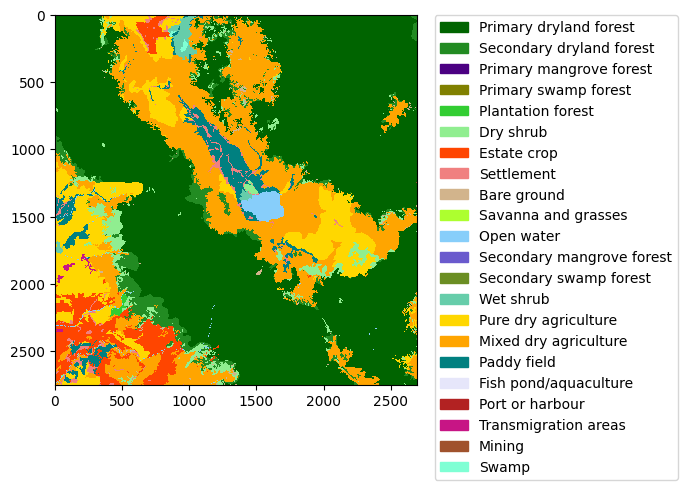

In [20]:
# Remap LC image data
for x in range(0, len(lc_df)):
	lc_dict = lc_df.loc[x]
	lc_image[lc_image == lc_dict['values']] = lc_dict['values_normalize']

# Show the land cover
plt.imshow(lc_image, cmap=cmap, interpolation='nearest', vmin=1, vmax=22)
plt.legend(**legend)

In [21]:
# Load satellite imagery
landsat = rio.open(landsat_dir)
landsat_image = landsat.read() / 1e4

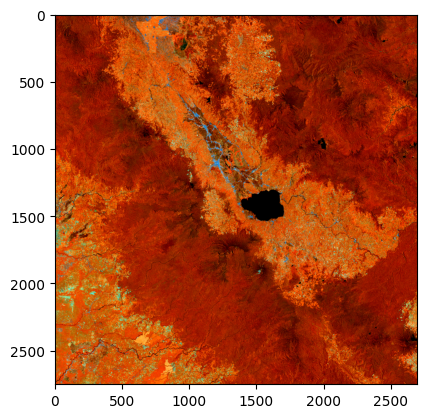

In [22]:
# Create a composite
composite = np.dstack([
	rescale_intensity(landsat_image[4], in_range=(0.125, 0.4), out_range=(0, 1)),
	rescale_intensity(landsat_image[5], in_range=(0.1, 0.3), out_range=(0, 1)),
	rescale_intensity(landsat_image[6], in_range=(0.075, 0.2), out_range=(0, 1))
])

# Visualize composite
plt.imshow(composite)

In [23]:
# Calculate unique values in the land cover
uniques = np.unique(lc_image)
uniques

array([ 1,  2,  5,  6,  7,  8,  9, 11, 14, 15, 16, 17, 20, 21, 22],
      dtype=int32)

## Generate Patches of Landsat Imagery and Land Cover ##

This part of the script purpose is to get list of patches coordinates in maximum and minimum of width and height of the imagery.

Then this coordinates used to get patches and transform to save the image as .tif.

In [24]:
# Width/height of the new image
image_width = 128

# Define image per land cover
image_per_lc = 20

plt.figure(figsize=(4 * image_per_lc, 4 * len(uniques)))

# Coords list
coords_dict = {}

# Get the land cover clip using the the width
for x in range(0, len(uniques)):
	# Get land cover class value
	lc = uniques[x]

	# Get list of image pixel coordinate with land cover values
	coords = np.argwhere(lc_image == lc)
	coords_filter = []

	# Filter only the one where it is not so close to the border of the image
	# Use the margin between the coordinate to the width of the patches
	for c in coords:
		cond1 = (c[0] - (image_width / 2)) >= 0
		cond2 = (c[1] - (image_width / 2)) >= 0
		cond3 = (c[0] + (image_width / 2)) <= lc_image.shape[0]
		cond4 = (c[1] + (image_width / 2)) <= lc_image.shape[1]

		if (cond1 & cond2 & cond3 & cond4):
			coords_filter.append(c)

	coords_dict[lc] = []

	# If the filtered coordinates is okay then generate the pixels bounds using min y, max y, min x, and max y
	if (len(coords_filter) > 0):

		# Sample only 20 of these coordinates
		seq = np.arange(len(coords_filter) - 1)
		sample = np.random.choice(seq, size=image_per_lc)
		sample_coord = list(map(lambda x: coords_filter[x], sample))

		# Generate the pixel bounds
		for y in range(0, len(sample_coord)):
			# Coordinate
			coord = sample_coord[y]

			# Min max of the coordinate
			max_y = int(coord[0] + (image_width / 2))
			min_y = int(coord[0] - (image_width / 2))
			max_x = int(coord[1] + (image_width / 2))
			min_x = int(coord[1] - (image_width / 2))

			# Add to the coordinate list
			coords_dict[lc].append([
				min_y,
				max_y,
				min_x,
				max_x
			])

<Figure size 8000x6000 with 0 Axes>

In [25]:
# Show, generate and save the patches of landsat image
plt.figure(figsize=(4 * image_per_lc, 4 * len(uniques)))

# Show the clipped image based on coordinate list
for x in range(0, len(uniques)):
	lc = uniques[x]
	coords_list = coords_dict[lc]

	for y in range(0, len(coords_list)):
		# Get the pixels bounds
		min_y, max_y, min_x, max_x = coords_list[y]

		# Get the image array based on bounds
		image_coord = composite[min_y:max_y, min_x:max_x]
		image_coord_t = np.transpose(image_coord, (2, 0, 1))

		id = f'{lc}_{y + 1}'

		# Get the transform to save the tif
		window = rio.windows.Window.from_slices((min_y, max_y), (min_x, max_x))
		transform = landsat.window_transform(window)

		# Save image as tiff
		output = rio.open(
			f'data/images/{id}.tif',
			'w',
			'COG',
			count=image_coord_t.shape[0],
			width=image_coord_t.shape[2],
			height=image_coord_t.shape[1],
			dtype='float32',
			compress='lzw',
			resampling=Resampling.nearest,
			transform=transform,
			crs=landsat.crs
		)
		output.write(image_coord_t)
		output.close()

		# Plot the preview image
		plt.subplot(len(uniques), image_per_lc, x * (image_per_lc) + y + 1)
		plt.imshow(image_coord)
		plt.title(f'{lc}_{y + 1}_[{min_y}, {min_y}, {min_x}, {max_x}]')

CPLE_OpenFailedError: Attempt to create new tiff file 'data/images/1_1.tif' failed: No such file or directory

<Figure size 8000x6000 with 0 Axes>

In [ ]:
# Show, generate and save the patches of landsat image
plt.figure(figsize=(4 * image_per_lc, 4 * len(uniques)))

# Show the clipped image based on coordinate list
for x in range(0, len(uniques)):
	lc = uniques[x]
	coords_list = coords_dict[lc]

	for y in range(0, len(coords_list)):
		# Get the pixels bounds
		min_y, max_y, min_x, max_x = coords_list[y]

		# Get the image using the coordinate with
		lc_coord = lc_image[min_y:max_y, min_x:max_x]

		id = f'{lc}_{y + 1}'

		# Get the transform to save the tif
		window = rio.windows.Window.from_slices((min_y, max_y), (min_x, max_x))
		transform = landsat.window_transform(window)

		# Save lc
		output = rio.open(
			f'data/lcs/{id}.tif',
			'w',
			'COG',
			count=1,
			width=lc_coord.shape[1],
			height=lc_coord.shape[0],
			dtype='uint8',
			compress='lzw',
			resampling=Resampling.nearest,
			transform=transform,
			crs=landsat.crs
		)
		output.write(lc_coord, 1)
		output.write_colormap(1, dict_palette)
		output.close()

		plt.subplot(len(uniques), image_per_lc, x * image_per_lc + y + 1)
		plt.imshow(lc_coord, cmap=cmap, interpolation='nearest', vmin=1, vmax=22)
		plt.title(f'{lc}_{y + 1}_[{min_y}, {min_y}, {min_x}, {max_x}]')